# Phenotypes

In this notebook, we analyze the data containing information about cell phenotypes.
To perform this analysis, it is necessary to first execute the script `dat_ph_aspect_ratio.py`, which processes the contents of the `dat` folder and generates the following output:

- A folder named `dat_phenotype`, which contains `.dat` files with the mean aspect ratio, the fraction of elongated cells, the fraction of round cells, and the fraction of binary cells at each time step and for each seed.

As mentioned above, there are three types of phenotypes, defined as follows:

- **Elongated cells**: Cells with maximum aspect ratio (specifically equal to 2.7) and maximum velocity.  
- **Round cells**: Passive cells with an aspect ratio equal to 1.  
- **Binary cells**: Cells with an aspect ratio between 1 and the maximum value, and a velocity greater than 0 but lower than the maximum.


## Phenotypes evolution

First of all, let's calculate how the phenotypes change in time arriving to an steady state for a given density.

In [1]:
# import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

We define some relevant parameters that remains constant during the simulations.

In [2]:
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each phenotype and the aspect ratio for each step.

In [3]:
def calculate_phenotype_vs_time(num_cells, dens, max_step, step, rng_seed):
    """
    Calculates phenotypes and the aspect ratio as a function of time
    for a given density and list of seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    """

    # Initialize the lists for each phenotype and the aspect ratio
    fraction_elongated = []
    fraction_round = []
    fraction_binary = []
    mean_aspect_ratio = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        fraction_elongated_cells_step = np.array([])
        fraction_round_cells_step = np.array([])
        fraction_binary_cells_step = np.array([])
        mean_aspect_ratio_step = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"data/{num_cells_folder}/{dens_folder}/dat_phenotype/phenotype_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            mean_aspect_ratio_seed = df_tic["mean_aspect_ratio"].mean()
            fraction_elongated_seed = df_tic["fraction_elongated"].mean()
            fraction_round_seed = df_tic["fraction_round"].mean()
            fraction_binary_seed = df_tic["fraction_binary"].mean()
            # Add them to the steps's array
            mean_aspect_ratio_step = np.append(mean_aspect_ratio_step, mean_aspect_ratio_seed)
            fraction_elongated_cells_step = np.append(fraction_elongated_cells_step, fraction_elongated_seed)
            fraction_round_cells_step = np.append(fraction_round_cells_step, fraction_round_seed)
            fraction_binary_cells_step = np.append(fraction_binary_cells_step, fraction_binary_seed)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        mean_aspect_ratio_mean = np.mean(mean_aspect_ratio_step)
        fraction_elongated_mean = np.mean(fraction_elongated_cells_step)
        fraction_round_mean = np.mean(fraction_round_cells_step)
        fraction_binary_mean = np.mean(fraction_binary_cells_step)

        # Add them to the global list
        mean_aspect_ratio.append(mean_aspect_ratio_mean)
        fraction_elongated.append(fraction_elongated_mean)
        fraction_round.append(fraction_round_mean)
        fraction_binary.append(fraction_binary_mean)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "mean_aspect_ratio": mean_aspect_ratio,
        "fraction_elongated": fraction_elongated,
        "fraction_round": fraction_round,
        "fraction_binary": fraction_binary,
    })

    return df

We also create a function to plot the phenotypes evolution.

In [5]:
def plot_phenotype_evolution(df, dens, num_cells):
    """
    Plots the temporal evolution of the phenotypes and mean aspect ratio
    for a given cell density.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the phenotypes and aspect ratio at 
        different time steps for each seed.
    dens : float
        Cell density used in the simulation.
    num_cells : int
        Number of cells in the simulation.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # First plot
    axs[0].plot(df["step"], df["fraction_elongated"], label="Fraction of elongated cells", color="red")
    axs[0].plot(df["step"], df["fraction_round"], label="Fraction of round cells", color="blue")
    axs[0].plot(df["step"], df["fraction_binary"], label="Fraction of binary cells", color="green")
    axs[0].set_title("Phenotypes")
    axs[0].set_ylabel("Fraction of cells")
    axs[0].legend()

    # Second plot
    axs[1].plot(df["step"], df["mean_aspect_ratio"], label="Mean aspect ratio", color="orange")
    axs[1].set_title("Mean aspect ratio")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Aspect ratio")
    axs[1].legend()

    fig.suptitle(f"Phenotypes and Mean Aspect Ratio vs Time (N={num_cells}, density = {dens})")
    plt.tight_layout()

    # Guardar el gráfico
    num_cells_folder = f"N={num_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/phenotypes/ph_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"ph_evolution_N={num_cells}_density_{dens:.2f}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

### Particular density and number of cells

In the case we want to see only one particular density and number of cells, continue as follows. We get the dataframe with the function and then plot it.

Last step =  50000  for density =  0.5


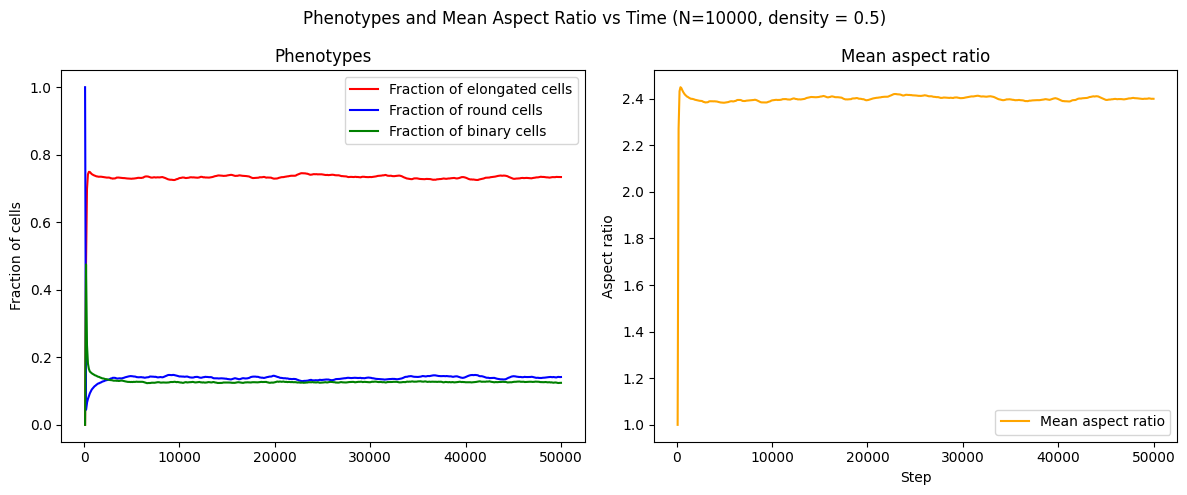

In [6]:
dens_input = input("Enter density (for example 0.50): ")
dens_nc = input("Enter number of cells (for example 10000): ")
try:
    density = float(dens_input)
    nc = int(dens_nc)
except ValueError:
    print("Error")
    exit()
df = calculate_phenotype_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
#df.to_csv("{density_folder}/ph_vs_time.csv", index=False)
plot_phenotype_evolution(df, dens=density, num_cells=nc)

### N=10_000

We can see how is the phenotypes evolution for each cell density in the case of N=10_000:

Last step =  50000  for density =  0.4


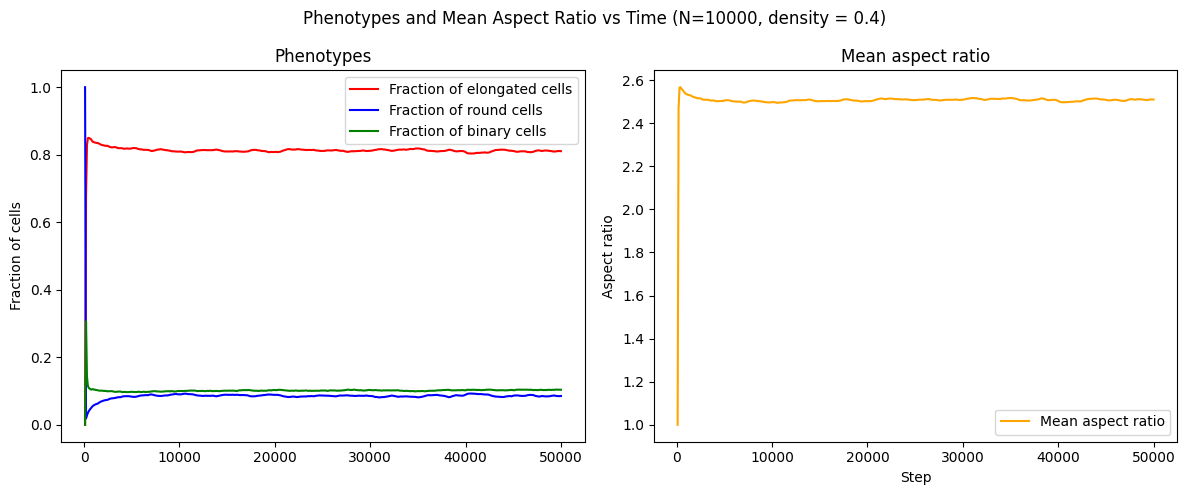

Last step =  50000  for density =  0.5


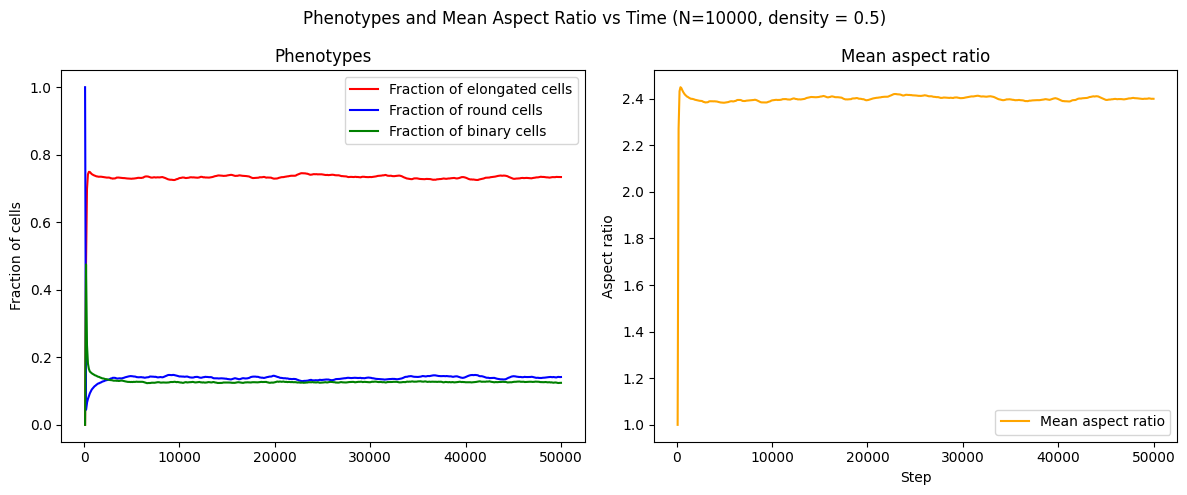

Last step =  50000  for density =  0.6


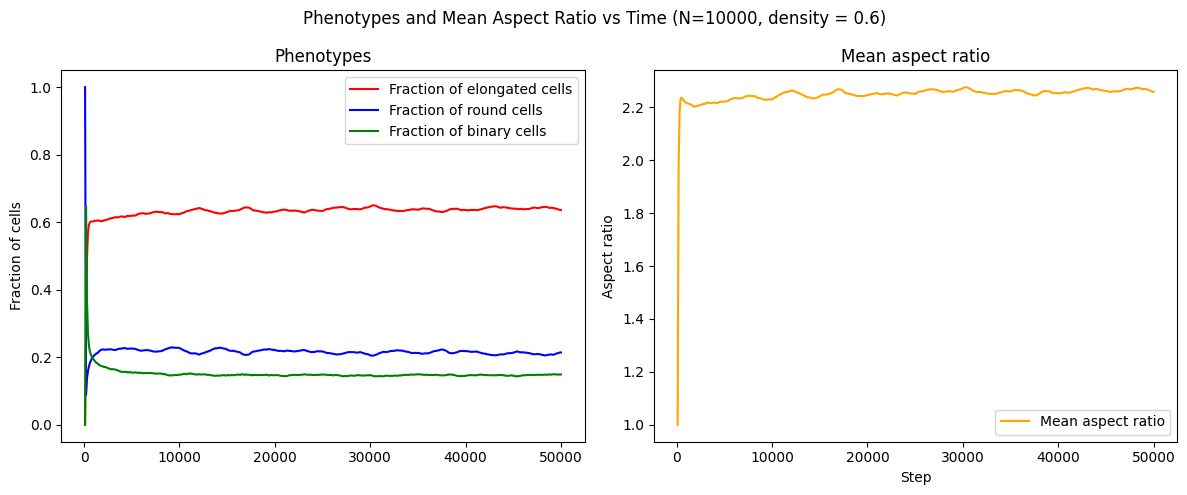

Last step =  50000  for density =  0.7


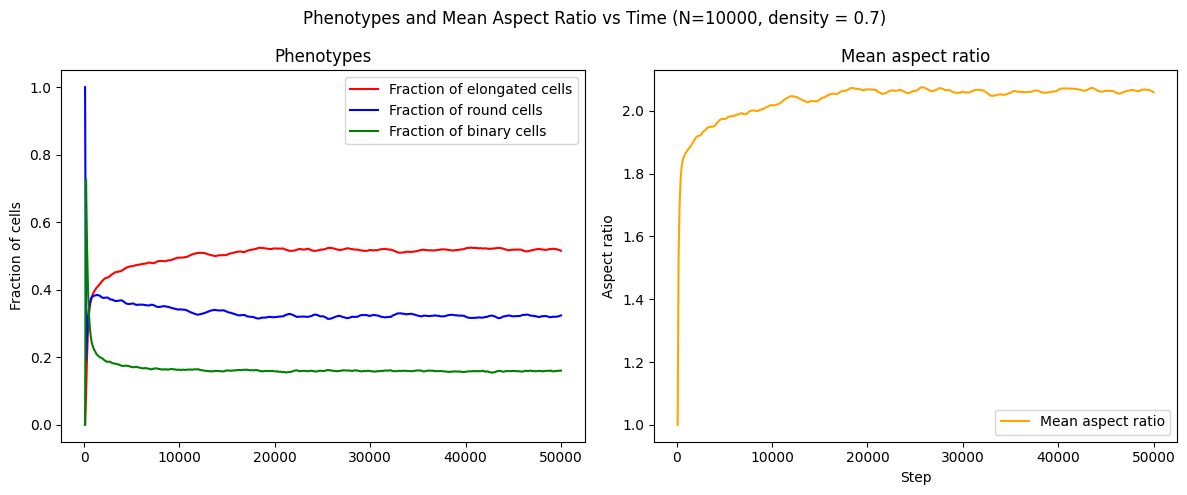

Last step =  50000  for density =  0.8


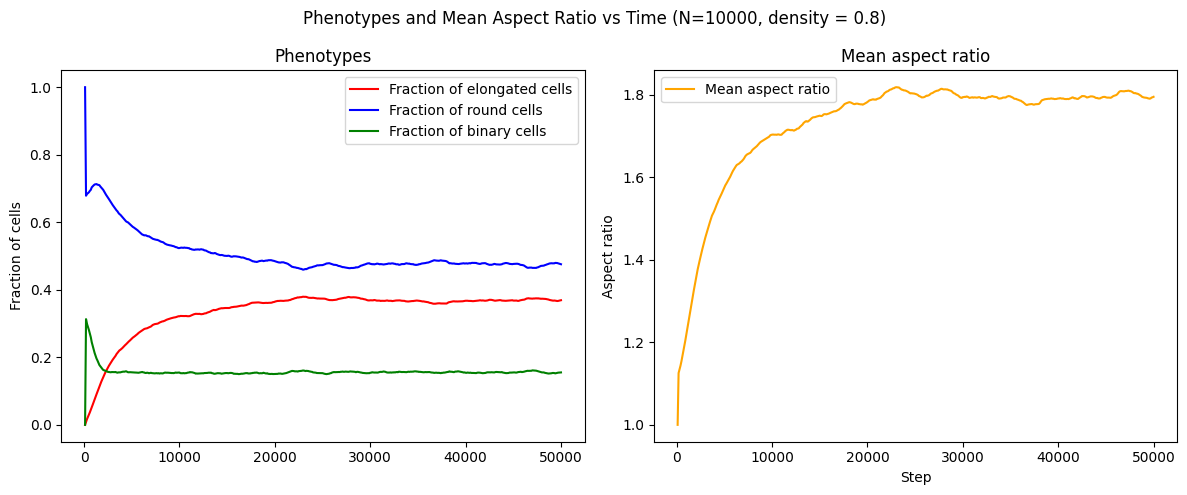

Last step =  50000  for density =  0.81


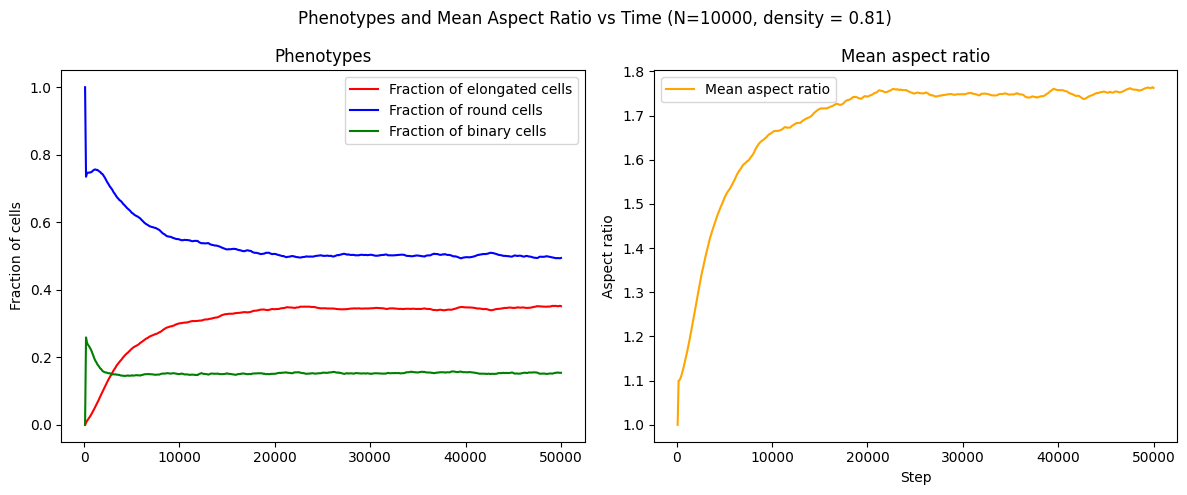

Last step =  50000  for density =  0.82


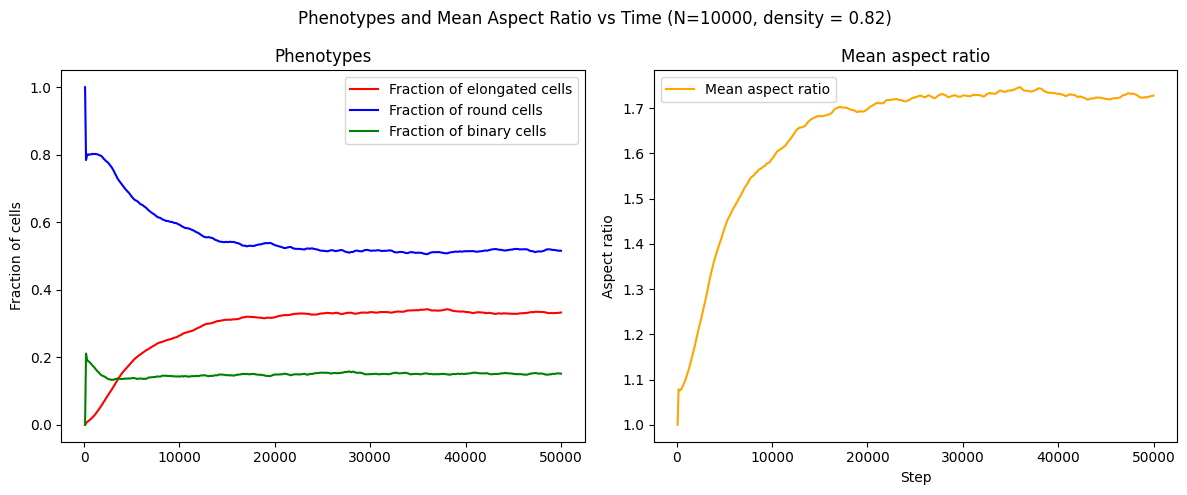

Last step =  47700  for density =  0.83


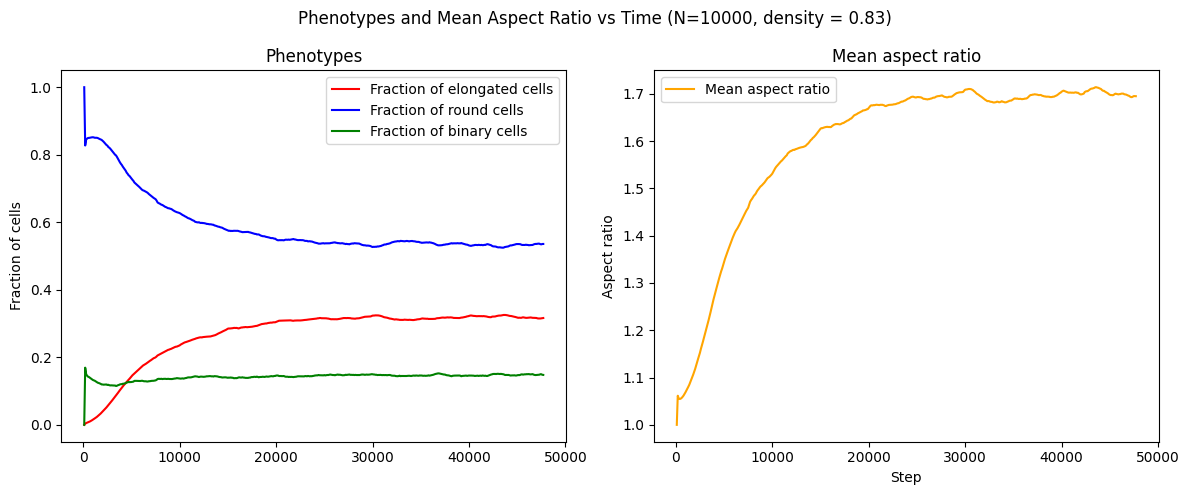

Last step =  45500  for density =  0.84


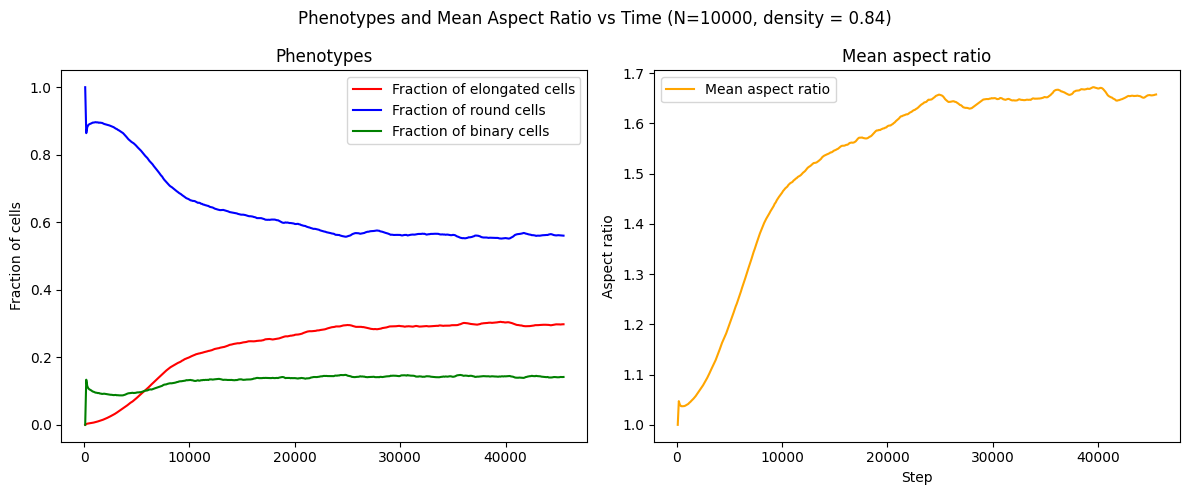

Last step =  48300  for density =  0.85


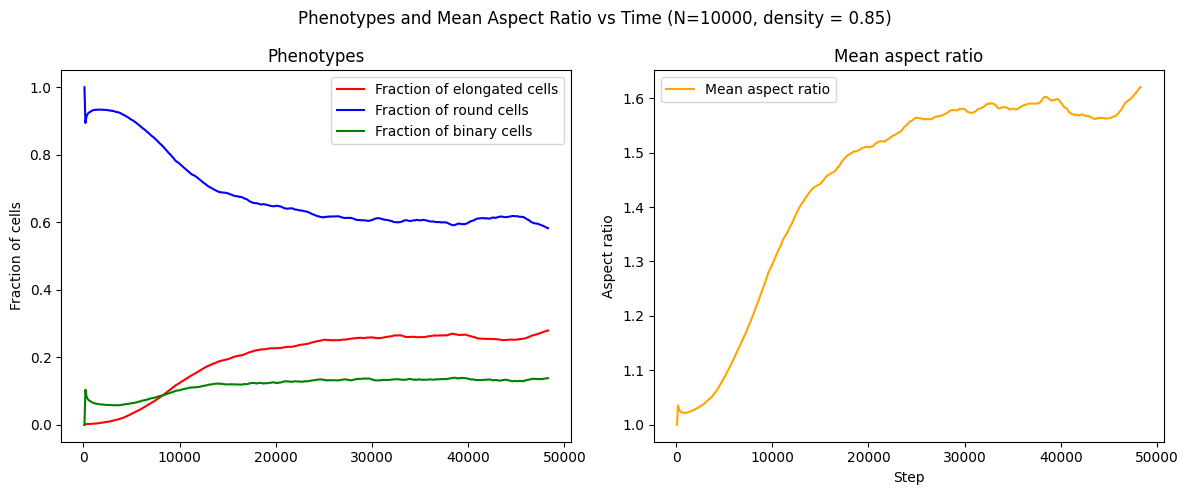

Last step =  45600  for density =  0.86


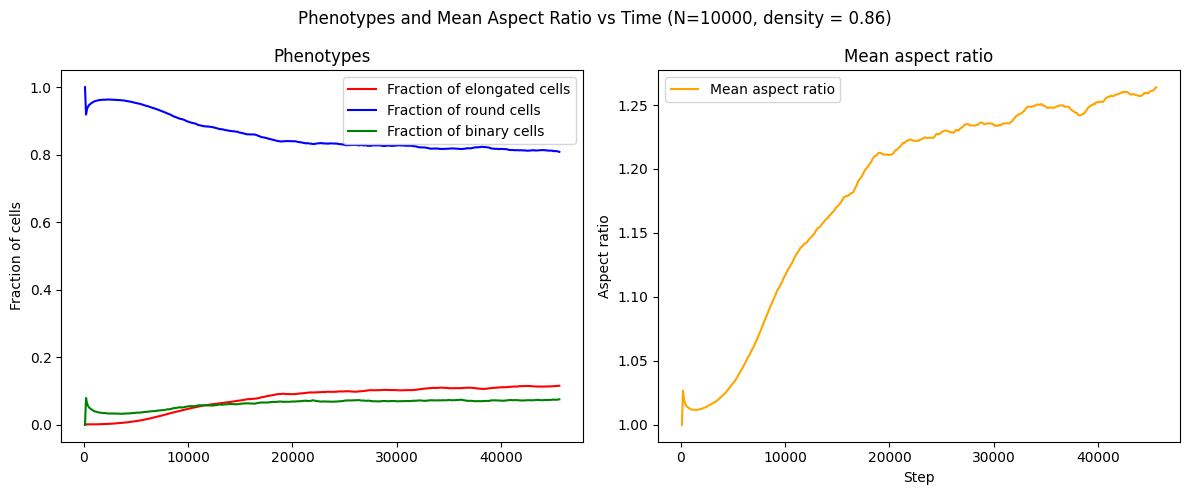

Last step =  29300  for density =  0.87


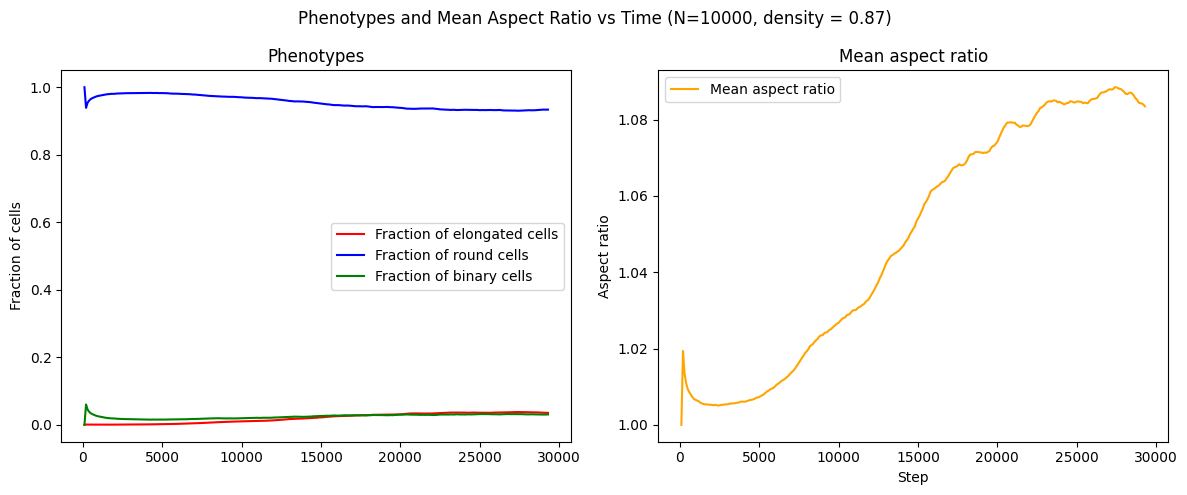

Last step =  10000  for density =  0.88


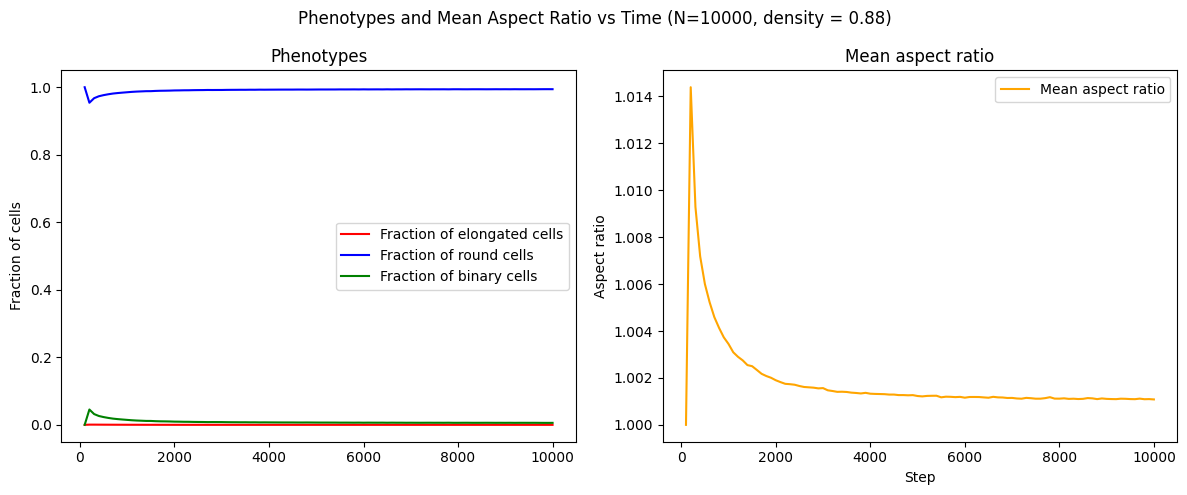

Last step =  10000  for density =  0.9


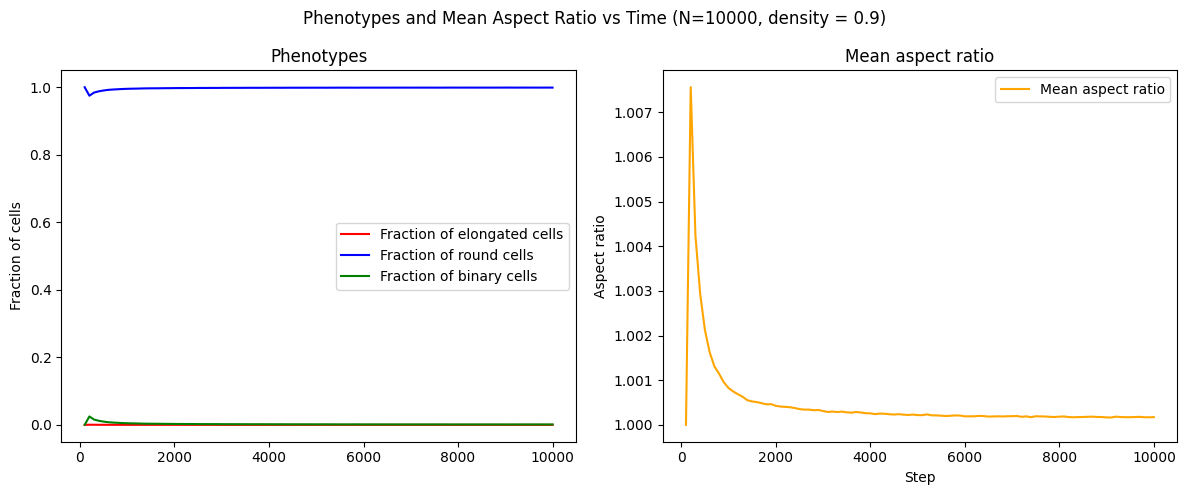

In [7]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a dict to save all the dataframes
# dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_phenotype_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/ph_vs_time_density_{density:.2f}.csv", index=False)
    # Add it to the dict
    # dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_phenotype_evolution(df, dens=density, num_cells=number_of_cells)

### N=5_000

We can see how is the phenotypes evolution for each cell density in the case of N=5_000:

Last step =  50000  for density =  0.7


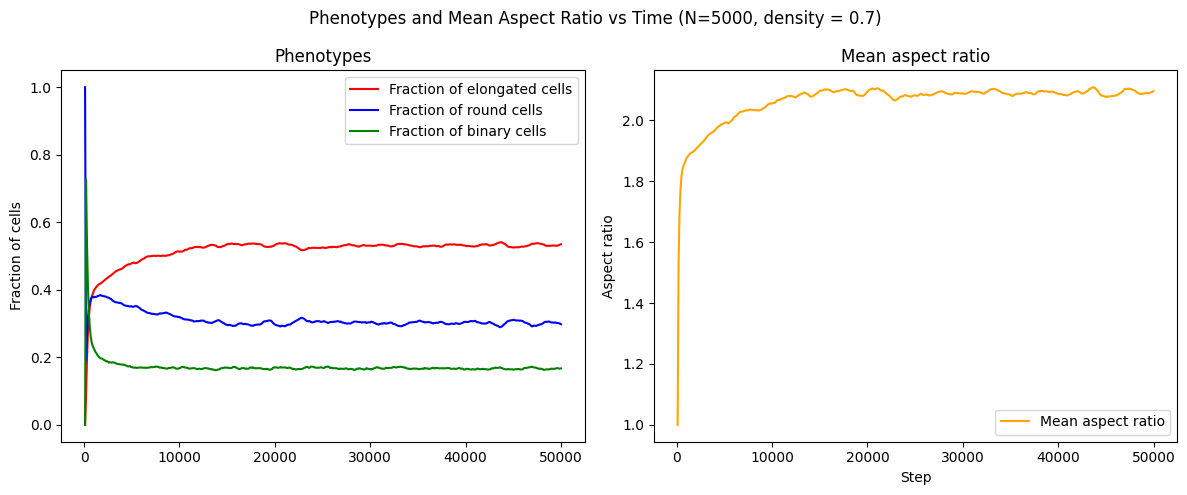

Last step =  50000  for density =  0.8


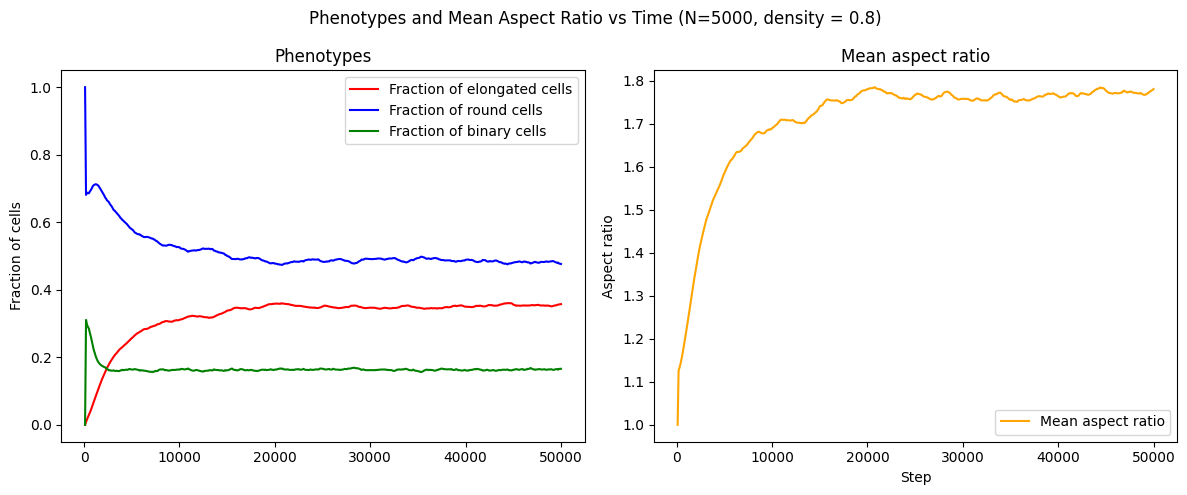

Last step =  13000  for density =  0.84


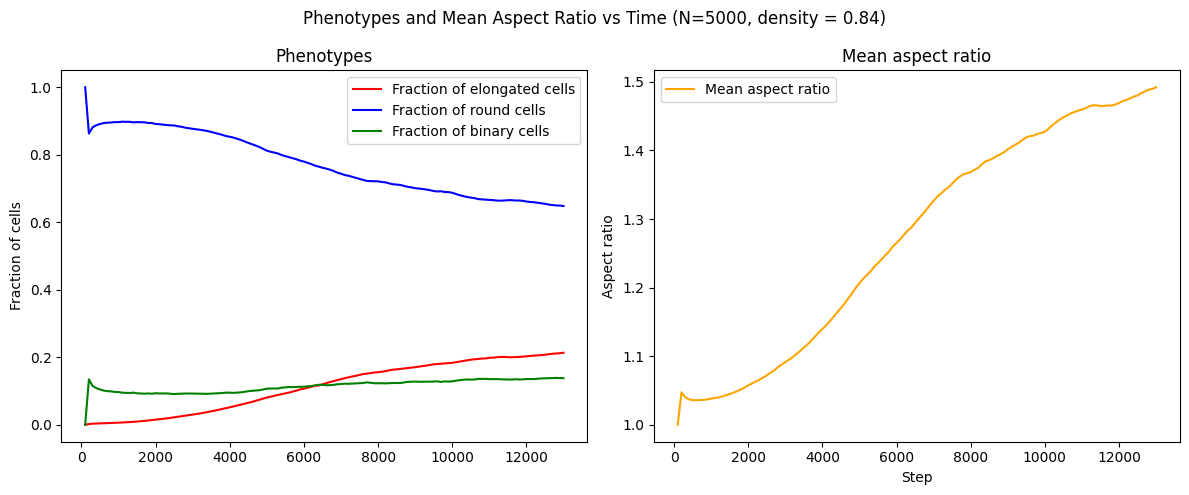

Last step =  25100  for density =  0.85


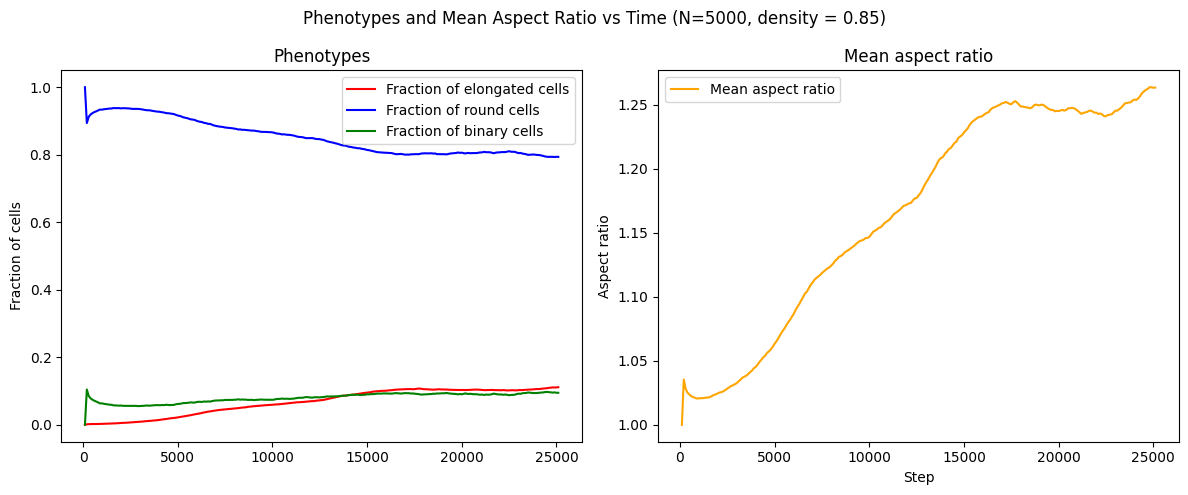

Last step =  12000  for density =  0.86


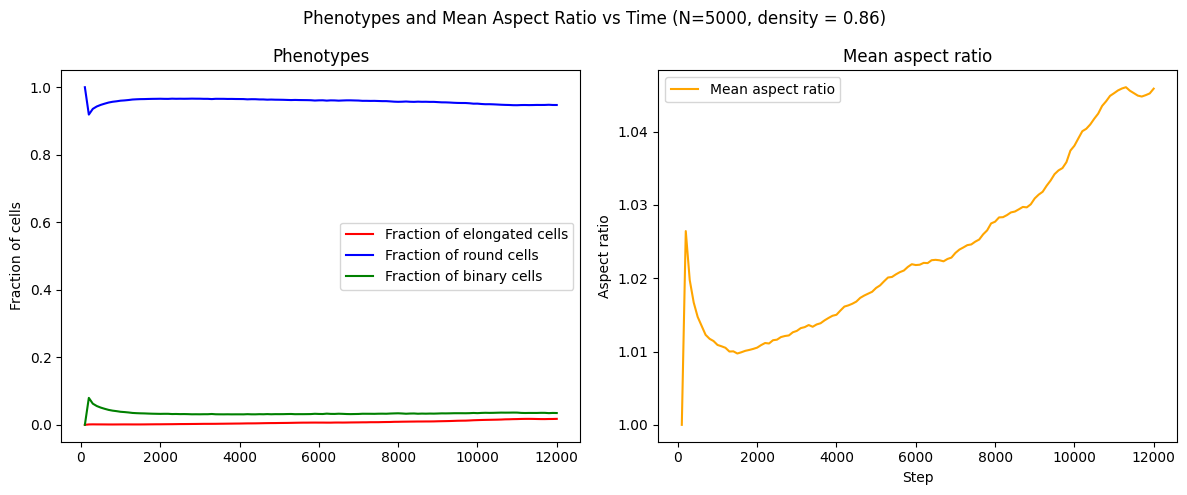

Last step =  10000  for density =  0.9


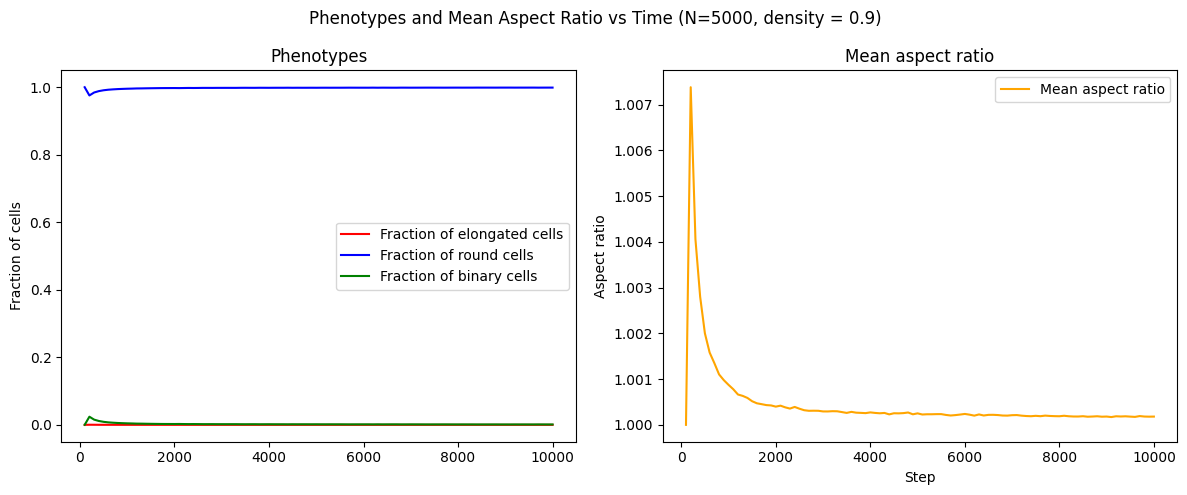

In [8]:
number_of_cells = 5_000
# Create a list with the densities
density_list = [0.7, 0.8, 0.84, 0.85, 0.86, 0.9]
# Create a dict to save all the dataframes
# dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_phenotype_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/ph_vs_time_density_{density:.2f}.csv", index=False)
    # Add it to the dict
    # dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_phenotype_evolution(df, dens=density, num_cells=number_of_cells)

### Steady State

Now we can plot how the final phenotypes change with the density.

First we create a function to calculate the phenotypes of the last step, saving the mean and the standard deviation.

In [9]:
def calculate_final_phenotype(num_cells, max_step, dens, step, rng_seed):
    """
    Calculates the final phenotypes and mean aspect ratio at the last 
    time step (`max_step`) for a given density, averaging over multiple seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    max_step : int
        Final time step to analyze.
    dens : float
        Cell density used in the simulation.
    step : int
        Time step interval between saved data files.
    rng_seed : list of int
        List of random seeds corresponding to different simulation runs.

    Returns
    -------
    dict
        Dictionary with the mean and standard deviation of the phenotypes
        and the mean aspect ratio at the final time step.
    """
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    # Define a boolean to stop where there are no more data
    stop = False
    # Check for which was the last step
    for tic in range(100, max_step, step):
        for seed in rng_seed:
            dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_phenotype/phenotype_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={tic:05}.dat"
            if not os.path.exists(dat_actual):
                stop = True
                break
        if stop is True:
            last_step = tic - step
            break
    else:
        # if the for does not break, last step is the max
        last_step = max_step
    
    print("Last step = ", last_step, " for density = ", dens)
    
    # Initialize the lists for phenotypes and mean aspect ratio
    fraction_elongated = []
    fraction_round = []
    fraction_binary = []
    mean_aspect_ratio = []
    # For each seed, we read de corresponding file 
    for seed in rng_seed:
        dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_phenotype/phenotype_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={last_step:05}.dat"

        if not os.path.exists(dat_actual):
            print(f"File not found: {dat_actual}")
            continue
        
        df_tic = pd.read_csv(dat_actual)
        # Take parameters of this particular seed
        mean_aspect_ratio_mean = df_tic["mean_aspect_ratio"].mean()
        fraction_elongated_mean = df_tic["fraction_elongated"].mean()
        fraction_round_mean = df_tic["fraction_round"].mean()
        fraction_binary_mean = df_tic["fraction_binary"].mean()

        # And add them to the list
        mean_aspect_ratio.append(mean_aspect_ratio_mean)
        fraction_elongated.append(fraction_elongated_mean)
        fraction_round.append(fraction_round_mean)
        fraction_binary.append(fraction_binary_mean)

    # return a dataframe with the mean and std for every op
    return {
        "mean": {
            "mean_aspect_ratio": np.mean(mean_aspect_ratio),
            "fraction_elongated": np.mean(fraction_elongated),
            "fraction_round": np.mean(fraction_round),
            "fraction_binary": np.mean(fraction_binary),
        },
        "std": {
            "mean_aspect_ratio": np.std(mean_aspect_ratio),
            "fraction_elongated": np.std(fraction_elongated),
            "fraction_round": np.std(fraction_round),
            "fraction_binary": np.std(fraction_binary),
        }
    }

Now we use this function to plot the steady states. We will need to create 2 DataFrames with the information of the mean and standard deviation for every density and give them to the plot function.

In [10]:
def plot_mean_and_variance_steady_states(df_mean, df_std, error_bars, var_names, labels, output_path, title):
    """
    Plots the mean and variance of each phenotype in the steady state.

    Parameters
    ----------
    df_mean : pandas.DataFrame
        DataFrame with mean values.
    df_std : pandas.DataFrame
        DataFrame with std values.
    error_bars : pandas.DataFrame
        DataFrame with standard error of the mean.
    var_names : list
        List of 4 labels for the legend.
    labels : list
        List of 4 labels for the legend.
    output_path: str
        Path to save the figure
    title: str
        Title of the whole figure
    """

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    color1, color2, color3, color4 = "red", "blue", "green", "orange"
    
    # First plot: mean with error bars phenotypes
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[0]], 
                 yerr=error_bars[var_names[0] + "_std"], fmt='o-', color=color1, label=labels[0])
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[1]], 
                 yerr=error_bars[var_names[1] + "_std"], fmt='o-', color=color2, label=labels[1])
    axes[0, 0].errorbar(df_mean["density"], df_mean[var_names[2]], 
                 yerr=error_bars[var_names[2] + "_std"], fmt='o-', color=color3, label=labels[2])
    axes[0, 0].set_xlabel("Density ρ")
    axes[0, 0].set_ylabel("Fraction of cells (mean)")
    axes[0, 0].set_title("Mean ± Std Error")
    axes[0, 0].legend()

    # Second plot: variance phenotypes
    axes[0, 1].plot(df_mean["density"], df_std[var_names[0] + "_std"]**2, marker='o', linestyle='--', color=color1, label=f"Var({labels[0]})")
    axes[0, 1].plot(df_mean["density"], df_std[var_names[1] + "_std"]**2, marker='o', linestyle='--', color=color2, label=f"Var({labels[1]})")
    axes[0, 1].plot(df_mean["density"], df_std[var_names[2] + "_std"]**2, marker='o', linestyle='--', color=color3, label=f"Var({labels[2]})")
    axes[0, 1].set_xlabel("Density ρ")
    axes[0, 1].set_ylabel("Variance")
    axes[0, 1].set_title("Variance")
    axes[0, 1].legend()

    # Third plot: mean with error bars mean aspect ratio
    axes[1, 0].errorbar(df_mean["density"], df_mean[var_names[3]], 
                 yerr=error_bars[var_names[3] + "_std"], fmt='o-', color=color4, label=labels[3])
    axes[1, 0].set_xlabel("Density ρ")
    axes[1, 0].set_ylabel("Aspect ratio (mean)")
    axes[1, 0].set_title("Mean ± Std Error")
    axes[1, 0].legend()

    # Second plot: variance mean aspect ratio
    axes[1, 1].plot(df_mean["density"], df_std[var_names[3] + "_std"]**2, marker='o', linestyle='--', color=color4, label=f"Var({labels[3]})")
    axes[1, 1].set_xlabel("Density ρ")
    axes[1, 1].set_ylabel("Variance")
    axes[1, 1].set_title("Variance")
    axes[1, 1].legend()

    fig.suptitle(title)
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

### N=10_000

Let's see the steady state of every density and N=10_000.

Last step =  50000  for density =  0.4
Last step =  50000  for density =  0.5
Last step =  50000  for density =  0.6
Last step =  50000  for density =  0.7
Last step =  50000  for density =  0.8
Last step =  50000  for density =  0.81
Last step =  50000  for density =  0.82
Last step =  47700  for density =  0.83
Last step =  45500  for density =  0.84
Last step =  48300  for density =  0.85
Last step =  45600  for density =  0.86
Last step =  29300  for density =  0.87
Last step =  10000  for density =  0.88
Last step =  10000  for density =  0.9


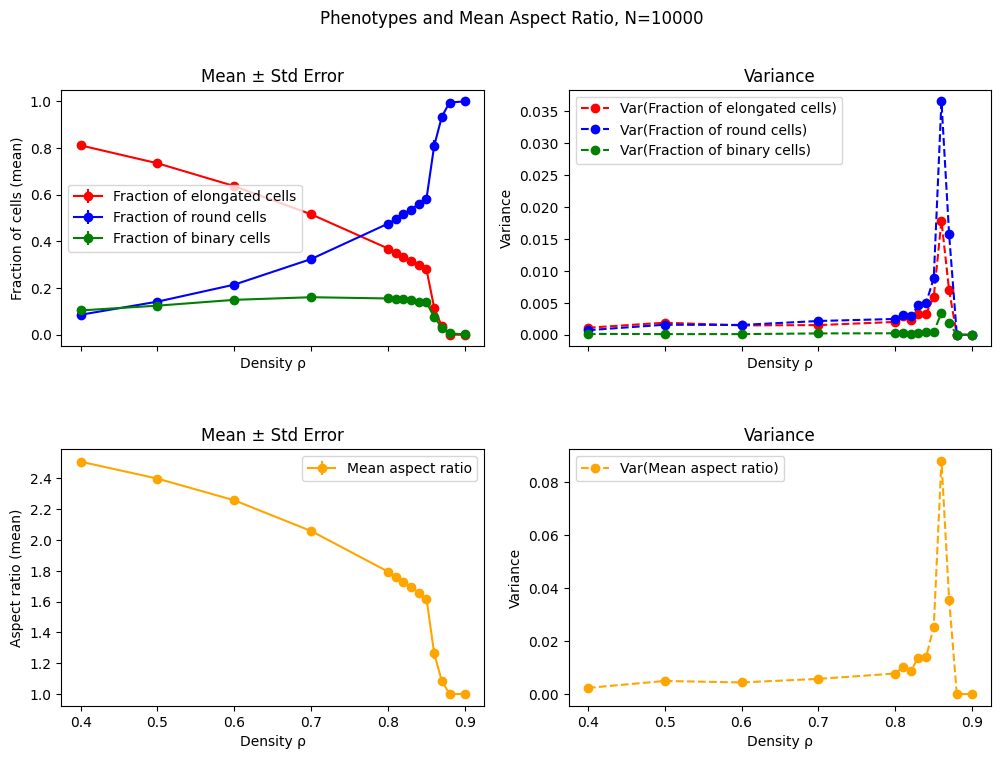

In [11]:
number_of_cells= 10_000
# Create a list with the densities
density_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Define DataFrames to save means and stds
df_mean = pd.DataFrame(columns=["density", "mean_aspect_ratio", "fraction_elongated", "fraction_round", "fraction_binary"])
df_std = pd.DataFrame(columns=["density", "mean_aspect_ratio_std", "fraction_elongated_std", "fraction_round_std", "fraction_binary_std"])

# For each density, calculate the phenotypes and add the results to the dataframes
for dens in density_list:
    result = calculate_final_phenotype(number_of_cells, max_step + 1, dens, step, rng_seed)
    mean = result["mean"]
    std = result["std"]

    df_mean.loc[len(df_mean)] = [dens, mean["mean_aspect_ratio"], mean["fraction_elongated"], mean["fraction_round"], mean["fraction_binary"]]
    df_std.loc[len(df_std)] = [dens, std["mean_aspect_ratio"], std["fraction_elongated"], std["fraction_round"], std["fraction_binary"]]

# Caclulate the length of the error bars
error_bars = df_std / np.sqrt(number_of_realizations)

num_cells_folder = f"N={number_of_cells:_}"
folder_path = f"graphs/{num_cells_folder}/phenotypes/ph_steady_state"
os.makedirs(folder_path, exist_ok=True)

plot_mean_and_variance_steady_states(
    df_mean=df_mean,
    df_std=df_std,
    error_bars=error_bars,
    var_names=["fraction_elongated", "fraction_round", "fraction_binary", "mean_aspect_ratio"],
    labels=["Fraction of elongated cells", "Fraction of round cells", "Fraction of binary cells", "Mean aspect ratio"],
    output_path=f"graphs/{num_cells_folder}/phenotypes/ph_steady_state/ph_steady_state_N={number_of_cells}.png",
    title=f"Phenotypes and Mean Aspect Ratio, N={number_of_cells}"
)

### N=5_000

Let's see the steady state of every density and N=5_000.

Last step =  50000  for density =  0.7
Last step =  50000  for density =  0.8
Last step =  13000  for density =  0.84
Last step =  25100  for density =  0.85
Last step =  12000  for density =  0.86
Last step =  10000  for density =  0.9


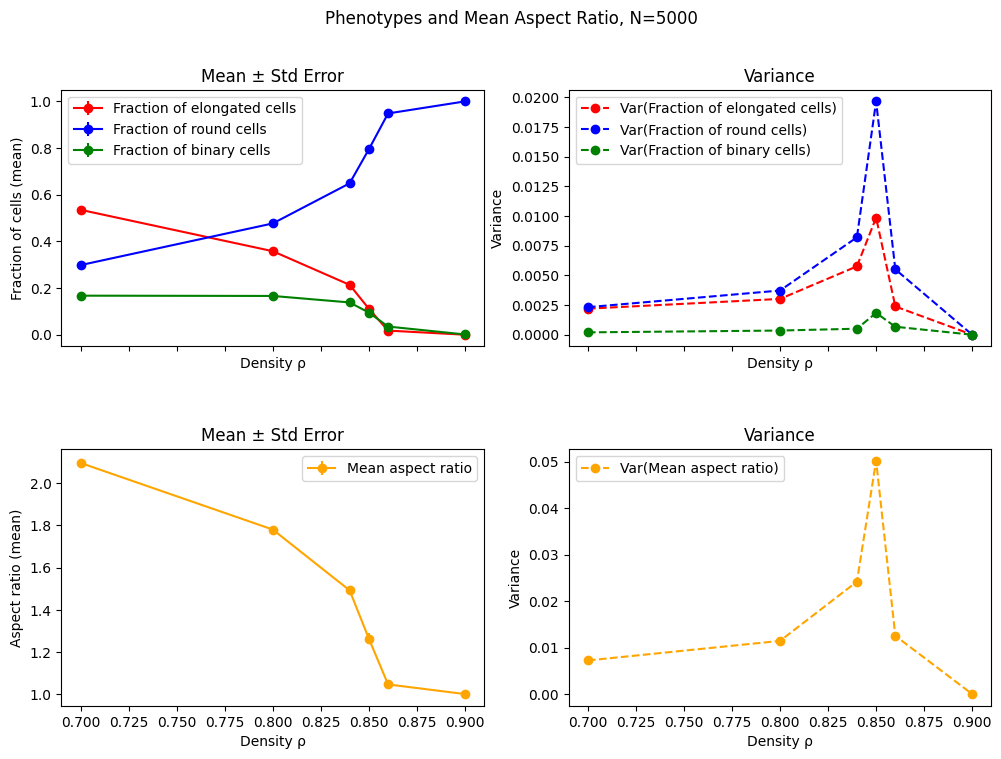

In [12]:
number_of_cells= 5_000
# Create a list with the densities
density_list = [0.7, 0.8, 0.84, 0.85, 0.86, 0.9]
# Define DataFrames to save means and stds
df_mean = pd.DataFrame(columns=["density", "mean_aspect_ratio", "fraction_elongated", "fraction_round", "fraction_binary"])
df_std = pd.DataFrame(columns=["density", "mean_aspect_ratio_std", "fraction_elongated_std", "fraction_round_std", "fraction_binary_std"])

# For each density, calculate the phenotypes and add the results to the dataframes
for dens in density_list:
    result = calculate_final_phenotype(number_of_cells, max_step + 1, dens, step, rng_seed)
    mean = result["mean"]
    std = result["std"]

    df_mean.loc[len(df_mean)] = [dens, mean["mean_aspect_ratio"], mean["fraction_elongated"], mean["fraction_round"], mean["fraction_binary"]]
    df_std.loc[len(df_std)] = [dens, std["mean_aspect_ratio"], std["fraction_elongated"], std["fraction_round"], std["fraction_binary"]]

# Caclulate the length of the error bars
error_bars = df_std / np.sqrt(number_of_realizations)

num_cells_folder = f"N={number_of_cells:_}"
folder_path = f"graphs/{num_cells_folder}/phenotypes/ph_steady_state"
os.makedirs(folder_path, exist_ok=True)

plot_mean_and_variance_steady_states(
    df_mean=df_mean,
    df_std=df_std,
    error_bars=error_bars,
    var_names=["fraction_elongated", "fraction_round", "fraction_binary", "mean_aspect_ratio"],
    labels=["Fraction of elongated cells", "Fraction of round cells", "Fraction of binary cells", "Mean aspect ratio"],
    output_path=f"graphs/{num_cells_folder}/phenotypes/ph_steady_state/ph_steady_state_N={number_of_cells}.png",
    title=f"Phenotypes and Mean Aspect Ratio, N={number_of_cells}"
)